In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import sim
import util
import torch
from IPython.display import clear_output
from models import GibbsLDA, CollapsedGibbsLDA, PyroLDA

clear_output()

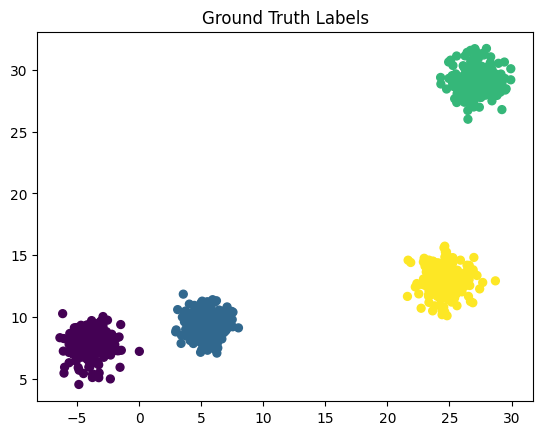

In [188]:
N_SAMPLES = 1000
N_FEATURES = 1000
N_TOPICS = 4
SCALE = 1
DISCRETIZE = False
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

In [189]:
from scipy.cluster.vq import kmeans, vq
from sklearn.neighbors import NearestNeighbors

In [190]:
neighbors = NearestNeighbors(n_neighbors=10).fit(X)

In [191]:
_, idx = neighbors.kneighbors(X)
idx

array([[  0, 651,  73, ..., 307, 417, 269],
       [  1, 170,  53, ..., 751, 109, 600],
       [  2, 197,  74, ..., 458, 527, 775],
       ...,
       [997, 735, 327, ..., 613, 970, 418],
       [998, 822, 753, ...,   8, 545, 944],
       [999, 364, 107, ..., 834, 645,  48]])

In [192]:
k = 15
iters = 100
codebook, variance = kmeans(X, k, iters)
codebook.shape

(15, 1000)

In [193]:
Y = np.zeros((X.shape[0], 10), dtype=np.int32)
for i in range(Y.shape[0]):
    Y[i], _ = vq(X[idx][i], codebook)
Y

array([[11, 11, 11, ..., 11, 11, 11],
       [11, 11, 11, ..., 11, 11, 11],
       [13, 13,  7, ...,  7, 13, 13],
       ...,
       [12, 12,  2, ..., 12, 12, 12],
       [11, 14, 11, ..., 11, 11, 11],
       [ 7,  7, 13, ..., 13,  7,  7]], dtype=int32)

In [194]:
values, _ = vq(X, codebook)
values

array([11, 11, 13, 14,  7,  7,  0,  7, 11,  5, 10, 14,  9,  6,  9,  8,  0,
       12, 11,  8,  7, 11,  0,  8,  8,  7, 11,  7, 12, 12,  2,  6, 11,  9,
       11,  9,  9, 11, 14, 12,  0,  2,  2,  0,  8, 11,  0, 12,  7,  0, 11,
        7, 11, 11, 11, 14, 12, 14, 12,  7,  3, 12,  8,  3,  7,  7, 12, 13,
       14,  8,  7, 14, 14, 11,  7, 11,  5,  8,  5, 12,  2,  3,  5,  9,  8,
       12,  7, 13,  3,  8, 13, 13,  7, 13,  9,  6, 11, 11,  3,  8,  5,  8,
       11,  0, 12,  7,  0, 13,  6, 11,  7, 10,  7, 12, 14,  9, 12, 13, 11,
        8, 11, 12, 13, 11,  7, 12,  8,  5, 12, 12, 13,  7,  0, 11, 11,  8,
        3, 14,  3, 12,  2, 14,  9,  1, 13,  7,  7,  9, 10, 10,  7, 11,  0,
       14, 12,  7, 10,  8, 13, 10, 12,  9, 13,  0, 11, 11, 14,  4,  7,  7,
       11,  0,  5,  9, 12, 13, 11,  9, 12, 13, 14,  8,  7, 12, 14, 13,  7,
        7,  5, 14,  2,  0, 12, 10,  3, 12, 14, 13,  2, 10,  7, 11,  0, 11,
       13, 14,  7,  2, 14, 13,  9,  2, 11,  0, 13,  6, 14,  0,  2,  9,  8,
        9, 10,  0, 12, 13

In [195]:
Z = np.concatenate([X[:, :2], values[None].T], -1)
Z.shape

(1000, 3)

In [196]:
N_DOCS = 150
doc_idx = np.random.permutation(Z.shape[0])[:N_DOCS]
doc_locs = Z[doc_idx, :2]
doc_locs.shape

(150, 2)

In [197]:
doc_assignments = np.random.choice(doc_locs.shape[0], X.shape[0])
Z = np.concatenate([Z, doc_assignments[None].T], -1)
Z.shape

(1000, 4)

In [198]:
topic_assignments = np.random.choice(N_TOPICS, X.shape[0])
Z = np.concatenate([Z, topic_assignments[None].T], -1)
Z.shape  # (x, y, value, doc, topic)

(1000, 5)

In [199]:
topic_word_counts = np.zeros((N_TOPICS, 15), dtype=np.int32)
for i in range(N_TOPICS):
    idx, counts = np.unique(Z[Z[:, -1] == i, -3], return_counts=True)
    topic_word_counts[i, idx.astype(np.int32)] = counts
topic_word_counts

array([[21,  0,  8,  8,  0,  9,  9, 49, 19,  8,  8, 47, 34, 22, 15],
       [20,  1, 12,  8,  1, 14,  7, 34, 21, 13,  4, 47, 21, 21, 17],
       [19,  0, 12,  8,  2, 12,  8, 46, 18, 13,  7, 45, 26, 20, 16],
       [22,  0, 10,  7,  1, 16,  8, 36, 23, 10,  8, 42, 24, 22, 21]],
      dtype=int32)

In [200]:
doc_topic_counts = np.zeros((N_DOCS, N_TOPICS), dtype=np.int32)
for i in range(150):
    idx, counts = np.unique(Z[Z[:, -2] == i, -1], return_counts=True)
    doc_topic_counts[i, idx.astype(np.int32)] = counts
doc_topic_counts

array([[0, 0, 0, 2],
       [0, 2, 1, 0],
       [5, 3, 2, 1],
       [3, 1, 3, 2],
       [4, 1, 2, 0],
       [2, 1, 3, 2],
       [2, 1, 0, 2],
       [1, 2, 1, 1],
       [2, 3, 2, 1],
       [1, 2, 1, 2],
       [2, 0, 1, 3],
       [0, 1, 1, 4],
       [1, 2, 0, 1],
       [1, 2, 2, 6],
       [3, 3, 1, 1],
       [1, 1, 3, 1],
       [2, 2, 6, 0],
       [5, 0, 3, 2],
       [4, 1, 2, 3],
       [2, 2, 4, 1],
       [2, 3, 4, 4],
       [3, 2, 1, 0],
       [1, 4, 3, 3],
       [2, 4, 2, 3],
       [2, 0, 1, 0],
       [1, 1, 1, 2],
       [2, 2, 1, 2],
       [0, 1, 1, 0],
       [4, 1, 2, 1],
       [7, 1, 1, 3],
       [1, 2, 1, 1],
       [3, 5, 0, 4],
       [2, 2, 2, 1],
       [2, 2, 1, 2],
       [2, 0, 1, 1],
       [0, 0, 0, 0],
       [1, 3, 4, 0],
       [1, 3, 1, 2],
       [2, 1, 3, 1],
       [3, 1, 0, 4],
       [1, 0, 1, 1],
       [2, 0, 2, 3],
       [1, 0, 0, 2],
       [1, 2, 2, 0],
       [0, 2, 1, 0],
       [1, 4, 0, 1],
       [3, 0, 1, 0],
       [2, 3,

In [201]:
from tqdm import tqdm

100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Score: 1.0


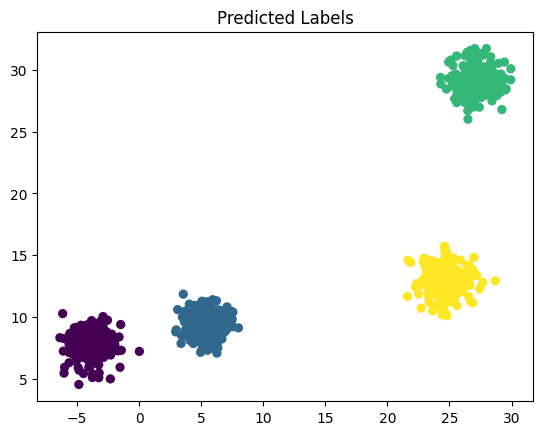

In [202]:
N_STEPS = 20
SIGMA = .5

likelihood_log = []

def sample_doc(word_x, word_y, old_topic):
    probs = np.exp(-((word_x - doc_locs[:, 0])**2 + (word_y - doc_locs[:, 1])**2)/SIGMA**2)*(doc_topic_counts[:, old_topic] + 1/N_DOCS)/(doc_topic_counts + 1/N_DOCS).sum(-1)
    probs /= probs.sum()
    doc = np.random.choice(probs.shape[0], p=probs)
    likelihood_log[-1] += probs[doc]
    return doc

def sample_topic(word_value, old_doc):
    topic_word_dist = (topic_word_counts[:, word_value] + 1/N_TOPICS)/(topic_word_counts + 1/N_TOPICS).sum(-1)
    doc_topic_dist = (doc_topic_counts[old_doc] + 1/N_DOCS)/(doc_topic_counts[old_doc] + 1/N_DOCS).sum()
    probs = topic_word_dist*doc_topic_dist
    probs /= probs.sum()
    topic = np.random.choice(probs.shape[0], p=probs)
    likelihood_log[-1] += probs[topic]
    return topic

for _ in tqdm(range(N_STEPS)):
    likelihood_log.append(0.)
    for i in range(Z.shape[0]):
        (word_x, word_y), (word_value, old_doc, old_topic) = Z[i, :2], Z[i, -3:].astype(np.int32)
        if topic_word_counts[old_topic, word_value] < 1 or doc_topic_counts[old_doc, old_topic] < 1:
            continue
        doc_topic_counts[old_doc, old_topic] -= 1
        topic_word_counts[old_topic, word_value] -= 1
        new_topic = sample_topic(word_value, old_doc)
        new_doc = sample_doc(word_x, word_y, old_topic)
        Z[i, -2], Z[i, -1] = new_doc, new_topic
        doc_topic_counts[new_doc, new_topic] += 1
        topic_word_counts[new_topic, word_value] += 1

Y_labels, score = util.evaluate(X_labels, Z[:, -1])
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

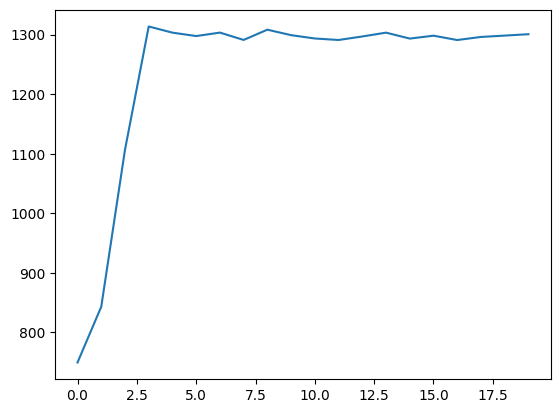

In [203]:
y = likelihood_log
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 20/20 [00:03<00:00,  5.47it/s]


Score: 0.885


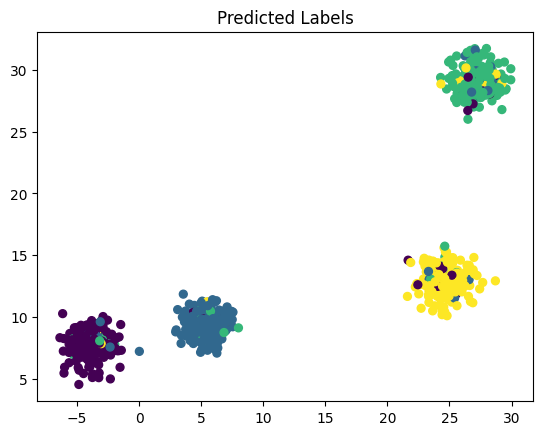

In [204]:
N_STEPS = 20

model = GibbsLDA(N_TOPICS).fit(Y, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

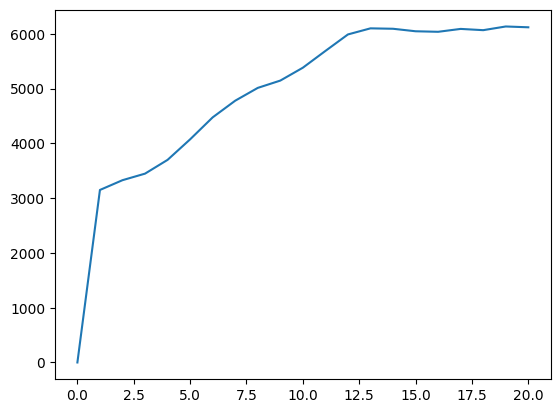

In [205]:
y = model.likelihood_log_
x = np.arange(len(y))
plt.plot(x, y);

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  6.70it/s]


Score: 0.993


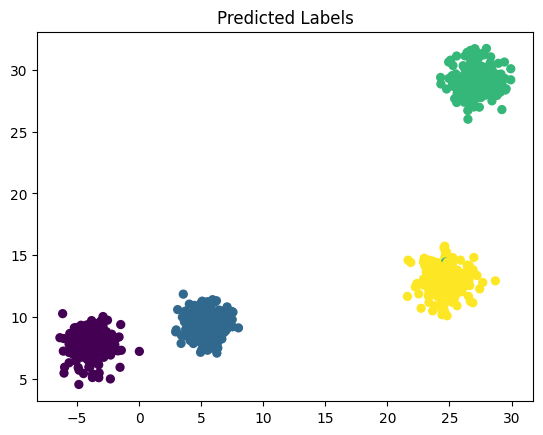

In [206]:
N_STEPS = 20

model = CollapsedGibbsLDA(N_TOPICS).fit(Y, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

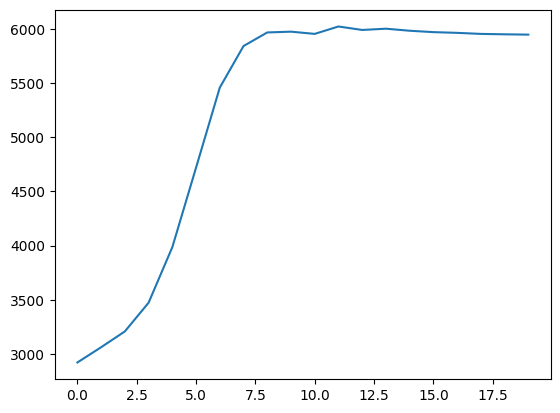

In [207]:
y = model.likelihood_log_
x = np.arange(len(y))
plt.plot(x, y);

100%|██████████| 1000/1000 [00:02<00:00, 387.54it/s]

Score: 1.0


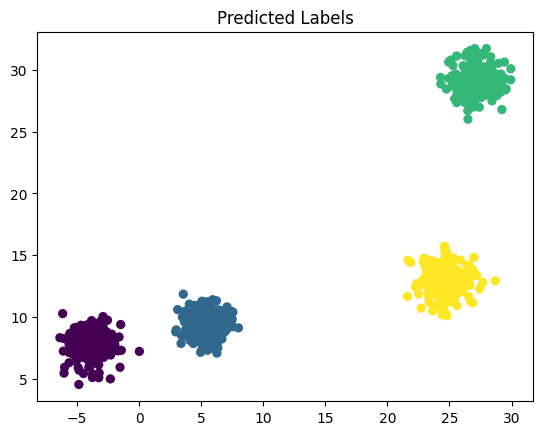

In [208]:
N_STEPS = 1000

pyro.clear_param_store()
Z = torch.tensor(Y).T
model = PyroLDA(N_TOPICS, batch_size=100).fit(Z, N_STEPS, 1e-1)
Y_labels, score = util.evaluate(X_labels, model.transform(Z))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

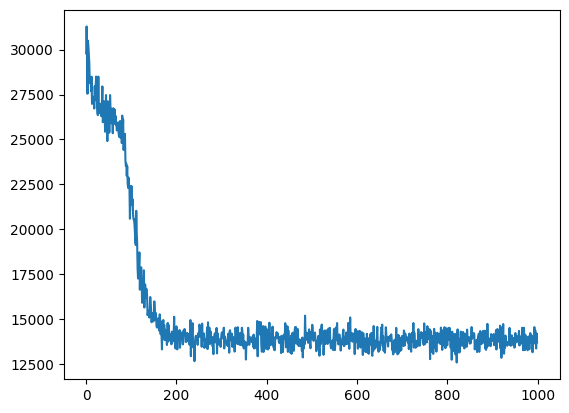

In [209]:
y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);